# aixtra Experimentation Notebook

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import itertools
import re
import uuid
import json

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [15]:
class UUIDEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, uuid.UUID):
      # if the obj is uuid, we simply return the value of uuid
      return str(obj)
    return json.JSONEncoder.default(self, obj)

## Load and show images

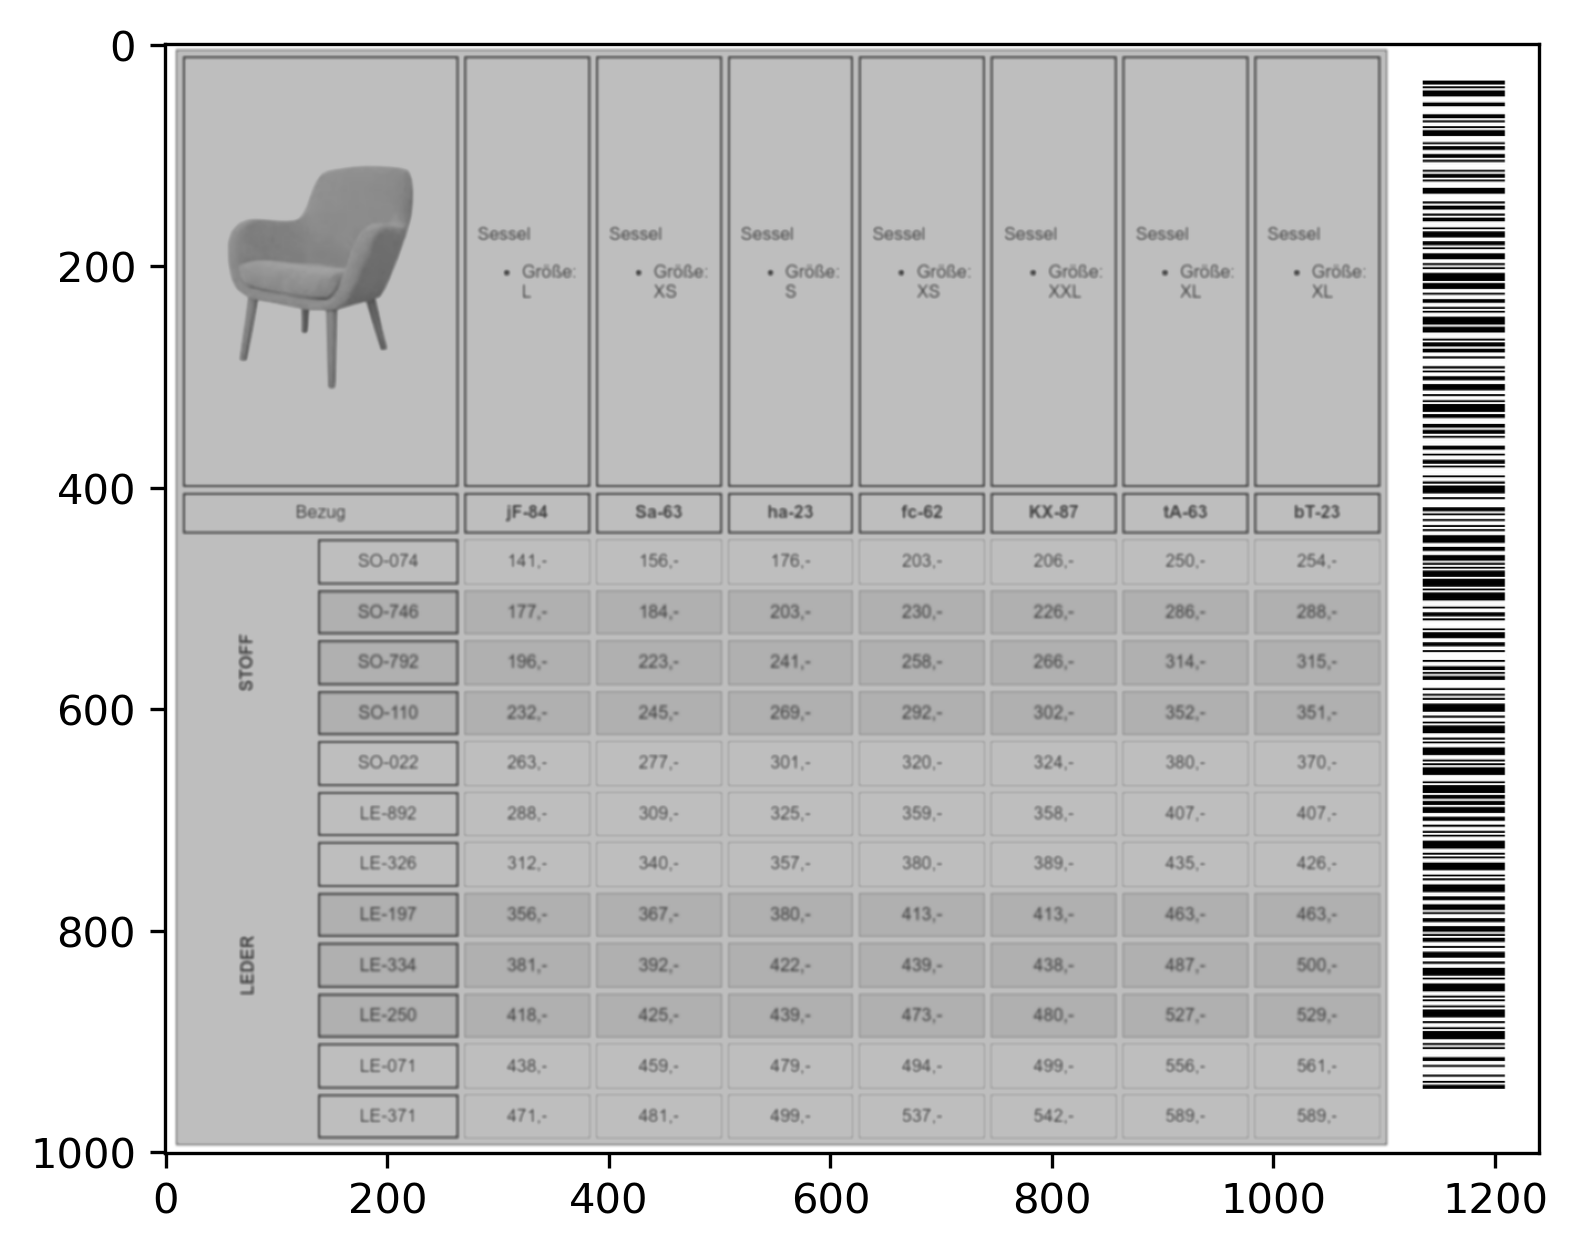

1240 1001


In [89]:
def show_image(opencv_img):
  rgb_im = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
  plt.imshow(rgb_im)
  plt.show()

image = cv2.imread("./images/image1.png", cv2.IMREAD_GRAYSCALE)

# Cut off some pixels from top and right
image = image[340:-413,:]
show_image(image)

height, width = image.shape
print(width, height)

## Image processing

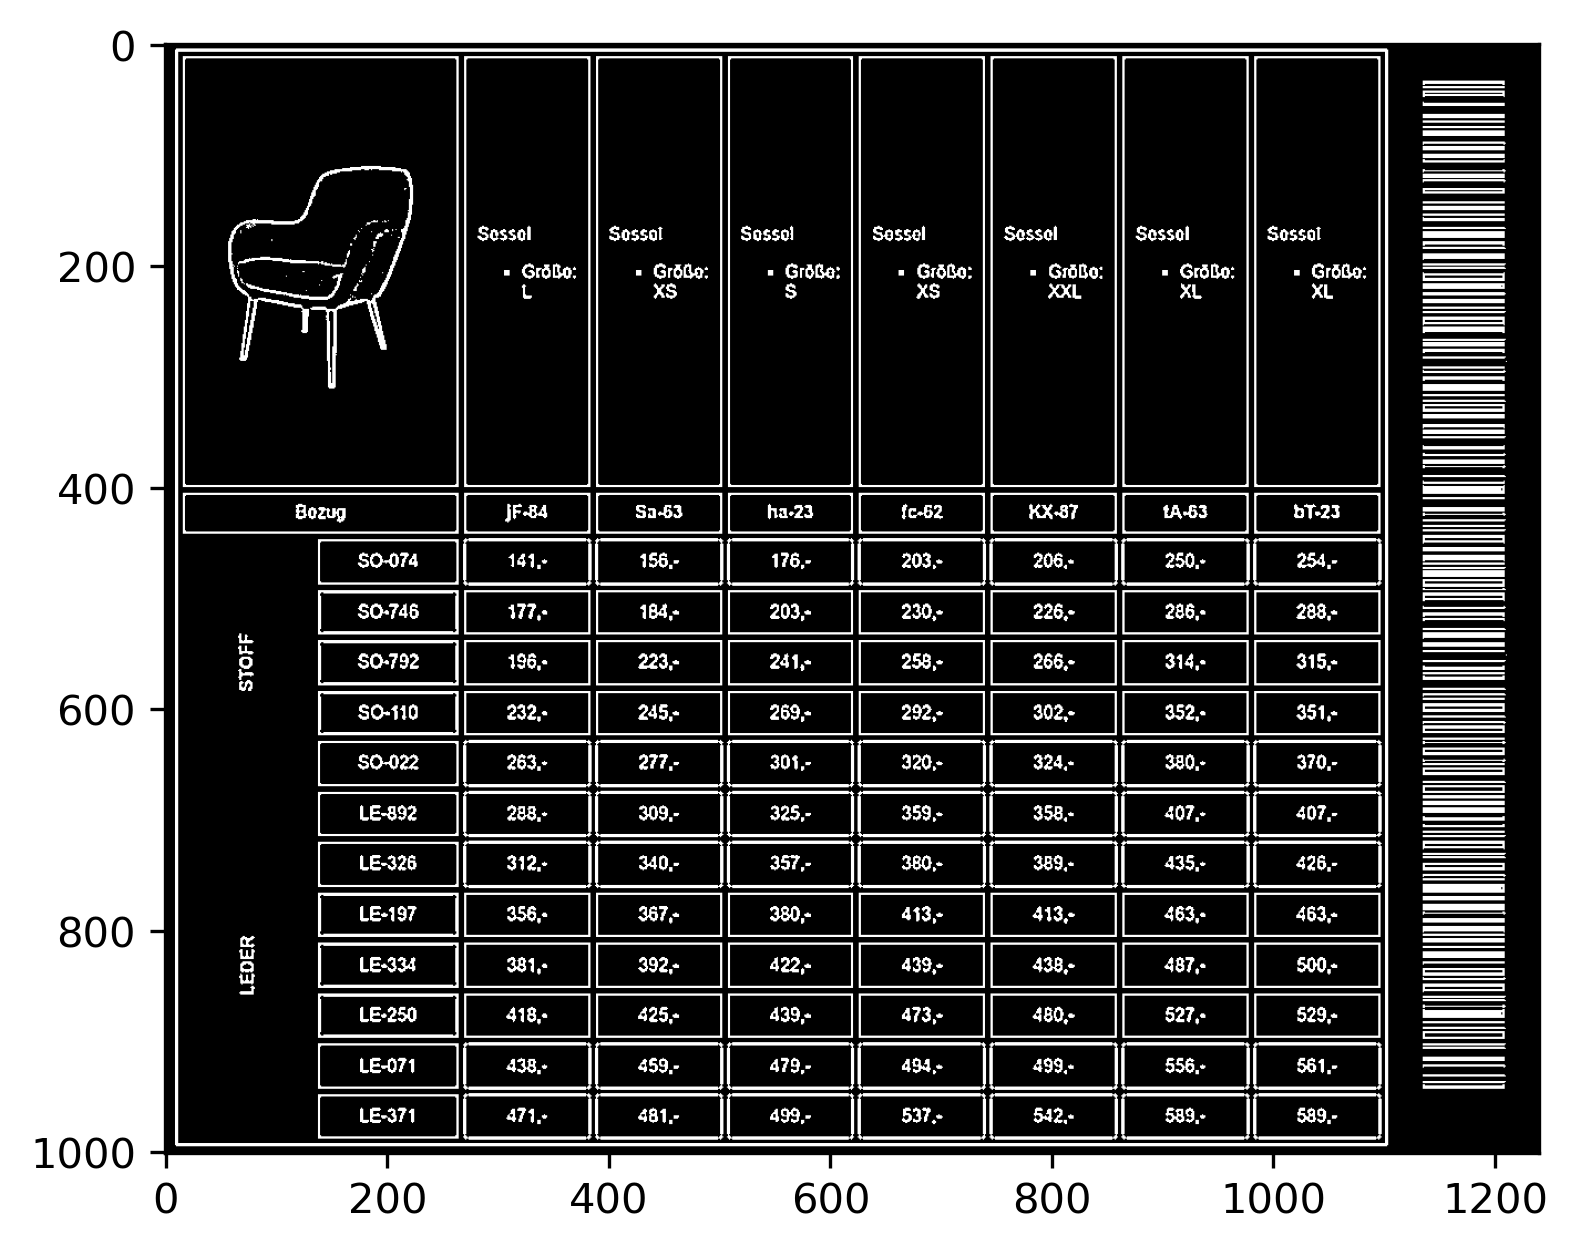

In [125]:
# Make image grayscale
thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)
thresholded_inv = 255-thresholded

plt.imshow(thresholded_inv,cmap='gray')
plt.show()

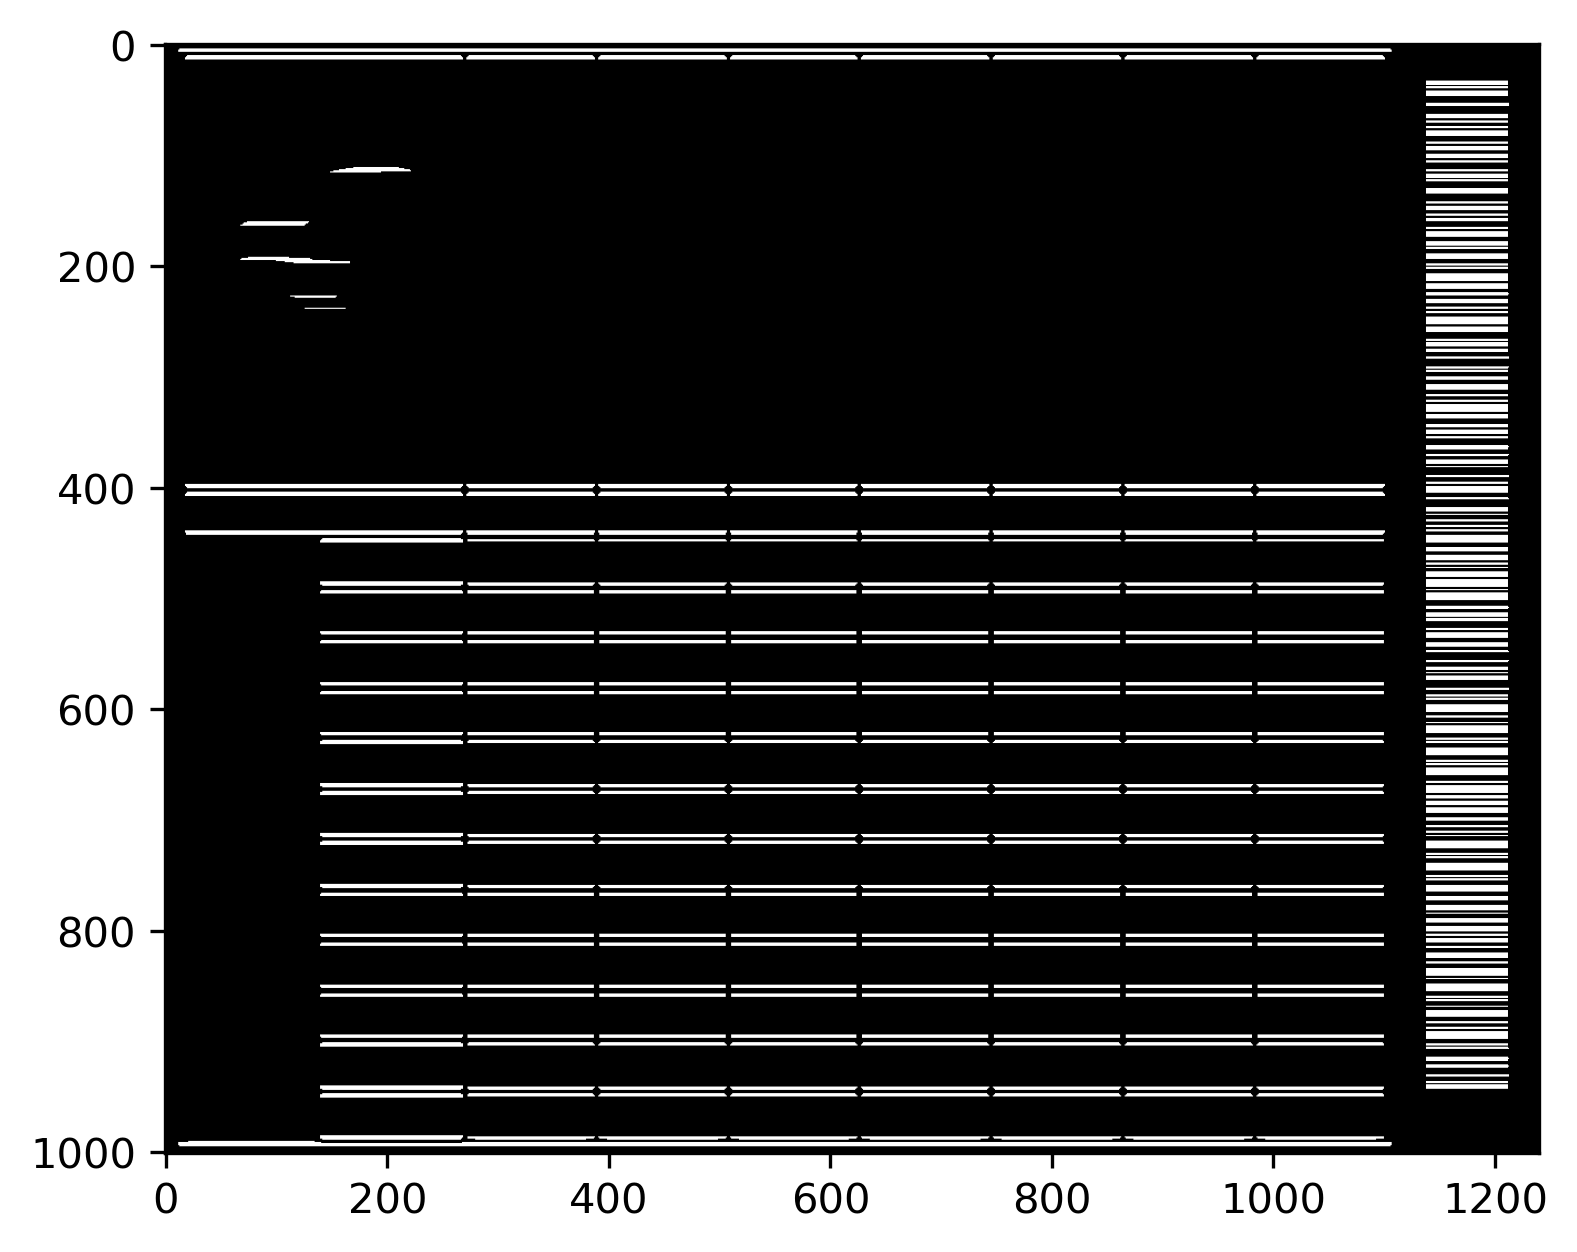

In [113]:
# Detect horizontal

length = np.array(image).shape[1]//100

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, 1))
horizontal_detect = cv2.erode(thresholded_inv, horizontal_kernel, iterations=3)
hor_lines = cv2.dilate(horizontal_detect, horizontal_kernel, iterations=3)

plt.imshow(hor_lines,cmap='gray')
plt.show()

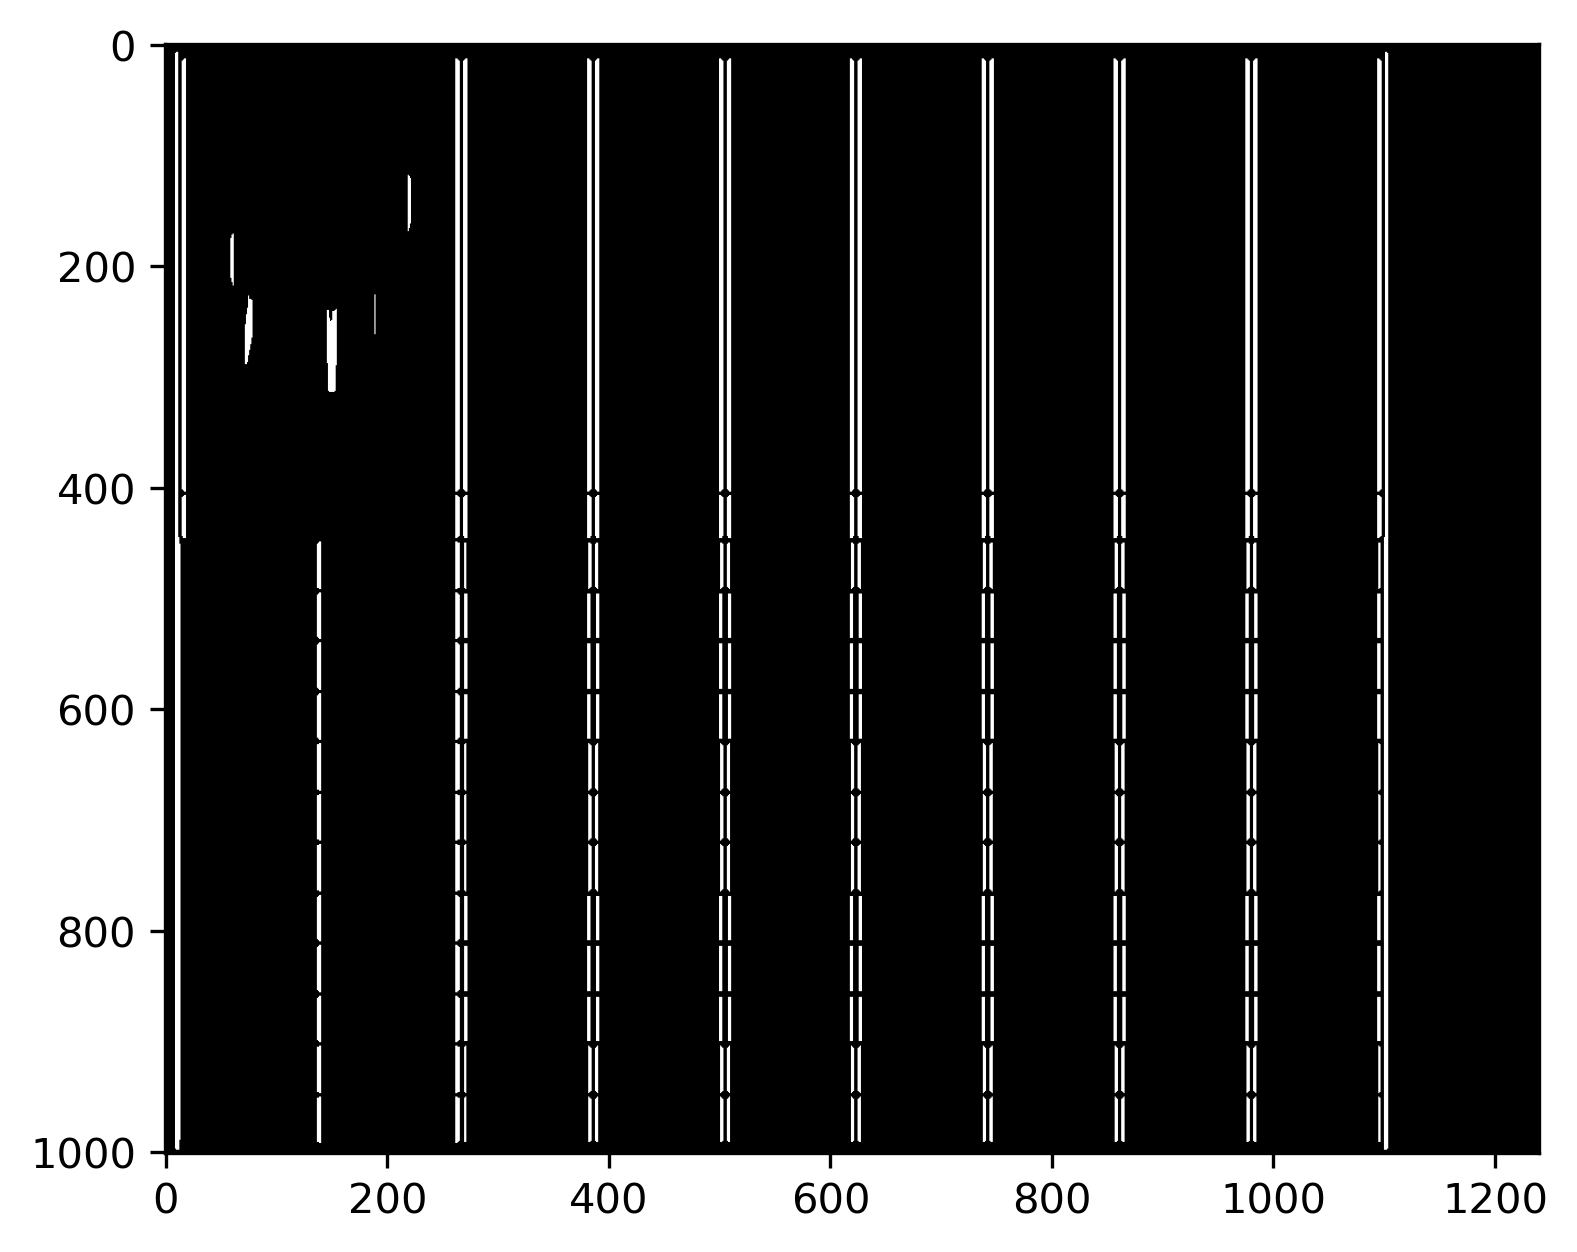

In [114]:
# Detect vertical

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, length))
vertical_detect = cv2.erode(thresholded_inv, vertical_kernel, iterations=3)
ver_lines = cv2.dilate(vertical_detect, vertical_kernel, iterations=3)

plt.imshow(ver_lines,cmap='gray')
plt.show()

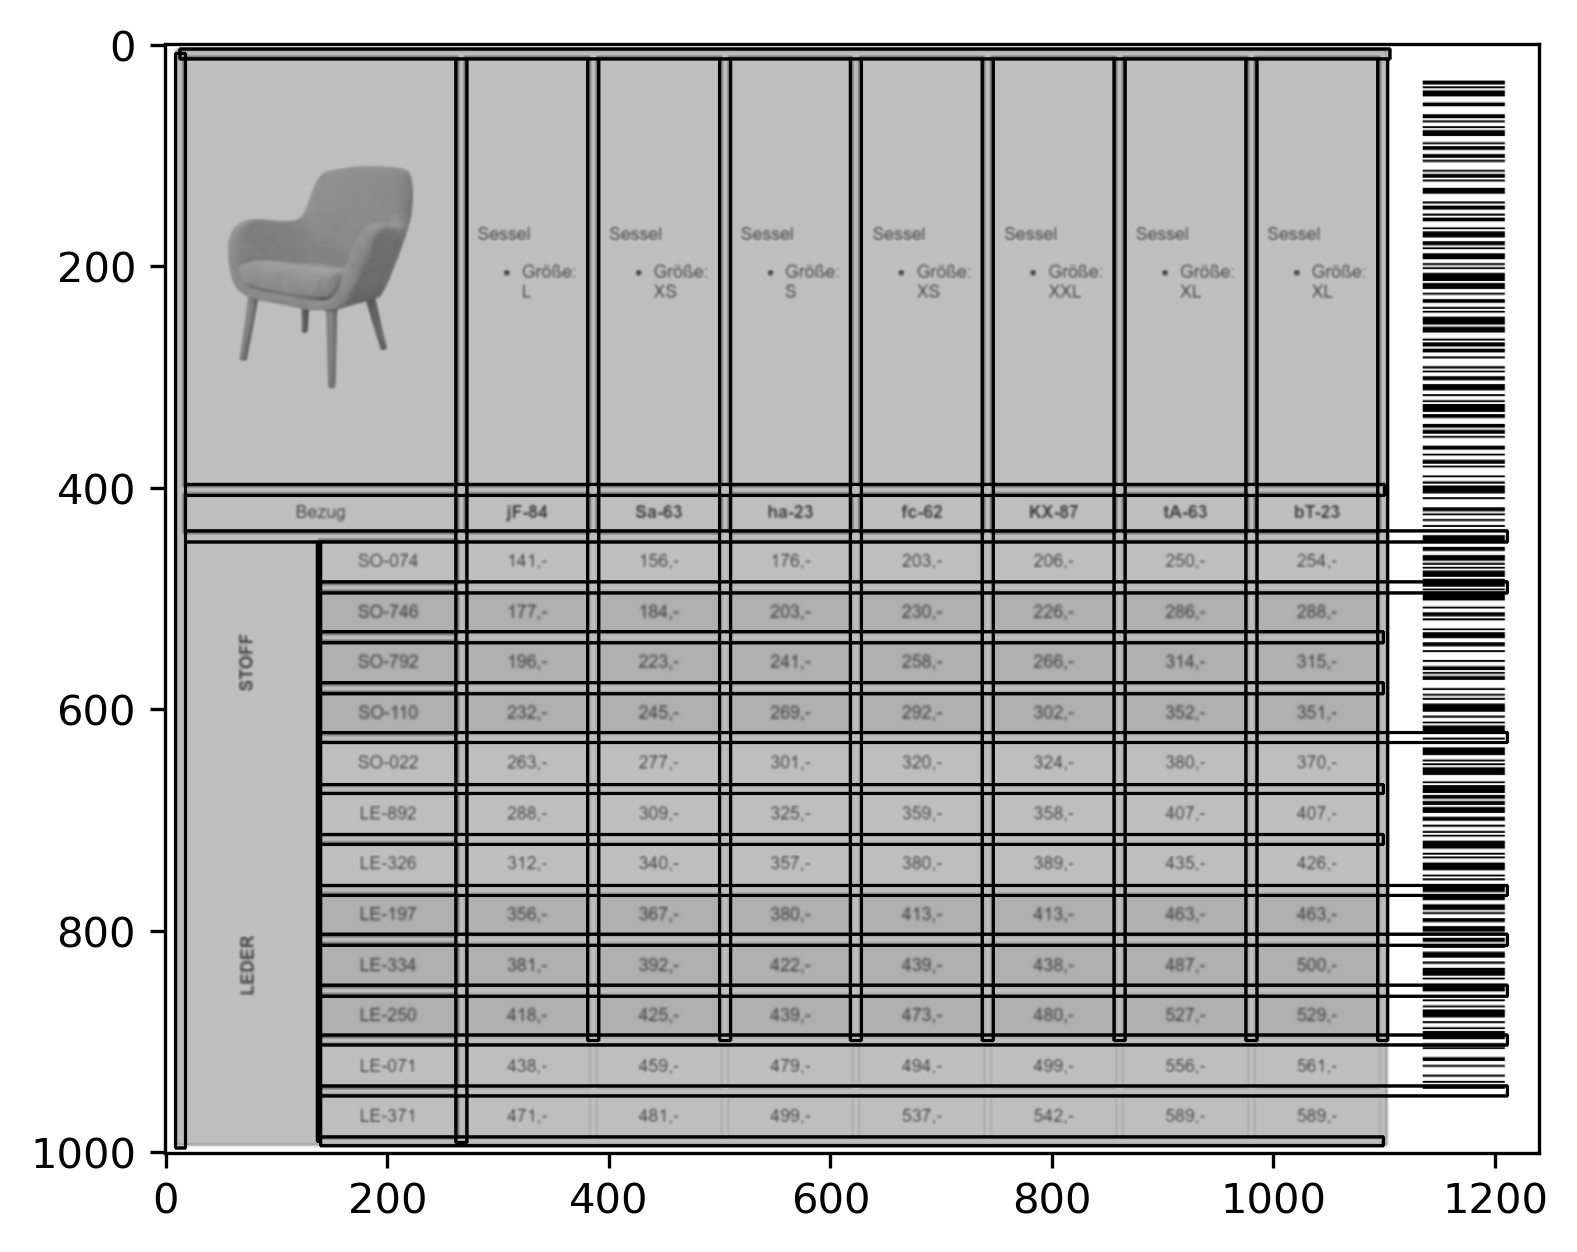

In [126]:
def find_long_horizontal_lines(hor_lines):
  # Find long horizontal lines that. They belong to our table.
  height, width = hor_lines.shape

  # Each entry is [row_start, row_end, col_start, col_end]
  hor_table_lines = []

  # We look for long lines in each row
  for row in range(height):
    line_pixels = 0
    line_start = None
    line_end = None

    for column in range(width):
      if hor_lines[row,column]:
        line_pixels += 1

        if not line_start:
          line_start = column

        line_end = column

    if line_pixels > 200 and line_start < width / 2:
      hor_table_lines.append([row, row, line_start, line_end])

  # Merge adjacent lines
  i = 0
  while i < len(hor_table_lines) - 1:
    curr = hor_table_lines[i]
    next = hor_table_lines[i + 1]

    if next[0] - curr[0] < 20:
      curr[1] = next[1]
      hor_table_lines.remove(next)
    else:
      i += 1

  return hor_table_lines


hor_table_lines = find_long_horizontal_lines(hor_lines)
ver_table_lines = [[*line[2:], *line[:2]] for line in find_long_horizontal_lines(ver_lines.T)]

# Output the found lines
temp_img = image.copy()
for line in [*hor_table_lines, *ver_table_lines]:
  cv2.rectangle(temp_img, (line[2], line[0]), (line[3], line[1]), 0, 2)
show_image(temp_img)

In [116]:
def get_row(index):
  """
  Return the start_y and end_y of the row with this index
  """
  return hor_table_lines[index][1] + 1, hor_table_lines[index + 1][0]

def get_column(index):
  """
  Return the start_x and end_x of the column with this index
  """
  return ver_table_lines[index][3] + 1, ver_table_lines[index + 1][2]

column_count = len(ver_table_lines) - 1
row_count = len(hor_table_lines) - 1

print([line[2] for line in ver_table_lines])
print([line[0] for line in hor_table_lines])

print(column_count)
print(row_count)

[9, 137, 262, 381, 500, 618, 737, 856, 975, 1094]
[4, 397, 439, 485, 530, 576, 621, 668, 713, 759, 803, 849, 894, 940, 986]
9
14


In [148]:
def parse_cell(row_start, column_start, row_end=None, column_end=None, rotate=False):
  start_y, end_y = get_row(row_start)
  start_x, end_x = get_column(column_start)

  if row_end:
    end_y = get_row(row_end)[1]

  if column_end:
    end_x = get_column(column_end)[1]

  cell = thresholded[start_y:end_y, start_x:end_x]

  if rotate:
    normalized = cv2.rotate(cell, cv2.ROTATE_90_CLOCKWISE)

  text = pytesseract.image_to_string(cell, lang="deu").strip()

  return text

In [149]:
def get_simple_features():
  start_y, end_y = get_row(0)

  simple_features = {}
  simple_feature_values = []

  for col_index in range(2, column_count):
    text = parse_cell(0, col_index)
    
    lines = text.split("\n")
    new_feature_indices = filter(lambda index: ":" in lines[index], range(len(lines)))
    feature_texts = [
      ' '.join(lines[start:end]) 
      for start, end in itertools.pairwise([*new_feature_indices, len(lines) + 1])
    ]

    print(lines)
    print(feature_texts)
    
    values = {}

    for feature_text in feature_texts:
      matches = re.findall("^\W*(\S+):\s+(.+)$", feature_text)
      
      if not matches:
        continue

      name, value = matches[0]
      name = name.strip()
      value = value.strip()

      if name not in simple_features:
        simple_features[name] = set([value])
      else:
        simple_features[name].add(value)

      values[name] = value

    simple_feature_values.append(values)

  simple_features = [
    {'name': name, 'values': list(value)} for name, value in simple_features.items()
  ]

  # If features are missing, we just add anything
  for feature_values in simple_feature_values:
    for feature in simple_features:
      if feature['name'] not in feature_values:
        feature_values[feature['name']] = feature['values'][0]
    
  return simple_features, simple_feature_values

simple_features, simple_feature_values = get_simple_features()
print(simple_features) 
print(simple_feature_values) 

['Sossol', '" Größe:', 'L']
['" Größe: L']
['Sossol', '" Größe:', 'x']
['" Größe: x']
['Sossel', '" Größe:', 's']
['" Größe: s']
['Sossel', '" Größe:', 'xS']
['" Größe: xS']
['Sessel', 'Größe:', 'XXL']
['Größe: XXL']
['Sossol', 'Größe:', 'x']
['Größe: x']
['Sossol', '" Größe:', 'XL']
['" Größe: XL']
[{'name': 'Größe', 'values': ['XL', 'x', 'xS', 's', 'XXL', 'L']}]
[{'Größe': 'L'}, {'Größe': 'x'}, {'Größe': 's'}, {'Größe': 'xS'}, {'Größe': 'XXL'}, {'Größe': 'x'}, {'Größe': 'XL'}]


In [150]:
# Check if a cell has a row delimiter at the top
def check_row_delimiter(row, column):
  start_x, end_x = get_column(column)

  return hor_table_lines[row][2] < end_x

In [151]:
# Parse the option range feature

def get_option_range():
  name = parse_cell(1, 0, 1, 1)
  
  # Find option range delimiters
  option_range_delimiter_indices = []
  for row_index in range(2, row_count):
    if check_row_delimiter(row_index, 0):
      option_range_delimiter_indices.append(row_index)

  option_range_delimiter_indices.append(row_count)

  # Parse option range names
  option_ranges = []

  for start, end in itertools.pairwise(option_range_delimiter_indices):
    option_ranges.append({
      'name': parse_cell(start, 0, row_end=end - 1, rotate=True),
      'values': [parse_cell(row, 1) for row in range(start, end)]
    })

  return name, option_ranges

option_range_feature, option_ranges = get_option_range()
print(option_range_feature)
print(option_ranges)

Bozug
[{'name': 'A4ols 83031', 'values': ['$0-074', '0746', '0.792', 'SOo-110', 'S002', 'LE-892', 'LE-326', 'LE-197', 'LE-334', 'LE-250', 'LE-071', 'LE-371']}]


In [152]:
def get_features():
  # Parse features in the format they want
  features = []

  # Put all the simple features in
  for feature in simple_features:
    id = uuid.uuid4()
    name = feature['name']

    features.append({
      'id': id,
      'nameInFormula': name,
      'optionRanges': [
        {
          'id': uuid.uuid4(),
          'name': name,
          'options': [
            {
              'id': uuid.uuid4(),
              'name': value
            }
            for value in feature['values']
          ]
        }
      ]
    })

  # Put the one complex feature in
  features.append({
    'id': uuid.uuid4(),
    'nameInFormula': option_range_feature,
    'optionRanges': [
      {
        'id': uuid.uuid4(),
        'name': option_range['name'],
        'options': [{
          'id': uuid.uuid4(),
          'name': value
        } for value in option_range['values']]
      }
      for option_range in option_ranges
    ]
  })

  return features

features = get_features()
print(json.dumps(features, indent=4, cls=UUIDEncoder))

[
    {
        "id": "3273eab4-62a0-4c38-9a16-48dde09b2c64",
        "nameInFormula": "Gr\u00f6\u00dfe",
        "optionRanges": [
            {
                "id": "493137e8-7211-4f88-9ba0-0f588faab5cf",
                "name": "Gr\u00f6\u00dfe",
                "options": [
                    {
                        "id": "69d56168-b9d8-485d-997f-e42884992a8f",
                        "name": "XL"
                    },
                    {
                        "id": "613b6045-45bd-459b-be48-11a0104ca909",
                        "name": "x"
                    },
                    {
                        "id": "b11acd0b-2e4c-4224-9d7c-5dd9746f476d",
                        "name": "xS"
                    },
                    {
                        "id": "5984216a-5636-4dfb-aad5-d52130d8a04f",
                        "name": "s"
                    },
                    {
                        "id": "e0ac9864-fa4c-4db3-b226-a37fd51a8cf2",
                      

In [153]:
def get_prices():
  prices = []

  # Calculate the prices. Go through all rows/columns.
  for col in range(2, column_count):
    # Values for simple features
    simple_vals = simple_feature_values[col - 2]

    for row in range(2, row_count):
      option_range_index = 0
      row_offset = 2
      while row - row_offset >= len(option_ranges[option_range_index]['values']):
        row_offset += len(option_ranges[option_range_index]['values'])
        option_range_index += 1
      option_index = row - row_offset    

      price = parse_cell(row, col)
      price = re.findall("^\D*(\d+)\D*$", price)
      if not price:
        continue
      price = int(price[0])

      prices.append({
        'id': uuid.uuid4(),
        'value': {
          'currencyUnit': 'EUR',
          'amountInMinorUnits': price * 100
        },
        'optionSelections': [*[
          {
            'featureId': features[-1]['id'],
            'optionId': features[-1]['optionRanges'][option_range_index]['options'][option_index]['id']
          }
        ], *[
          {
            'featureId': features[feature_index]['id'],
            'optionId': features[feature_index]['optionRanges'][0]['options'][simple_feature['values'].index(simple_vals[simple_feature['name']])]['id']
          }
          for feature_index, simple_feature in enumerate(simple_features)
        ]]
      })    
    
    return prices

prices = get_prices()  
print(json.dumps(prices, indent=4, cls=UUIDEncoder))

[
    {
        "id": "dfcd1188-17c9-4150-a75b-de46592ae4fa",
        "value": {
            "currencyUnit": "EUR",
            "amountInMinorUnits": 18100
        },
        "optionSelections": [
            {
                "featureId": "4669490d-14fe-45cd-afbd-16e32a9b73e9",
                "optionId": "8258ea58-da77-48bf-b91d-efae2fe6ed18"
            },
            {
                "featureId": "3273eab4-62a0-4c38-9a16-48dde09b2c64",
                "optionId": "30650719-1c16-4c41-af70-320933d44304"
            }
        ]
    },
    {
        "id": "f7bab8cf-df00-4cf0-a0c6-7743eac162e7",
        "value": {
            "currencyUnit": "EUR",
            "amountInMinorUnits": 19800
        },
        "optionSelections": [
            {
                "featureId": "4669490d-14fe-45cd-afbd-16e32a9b73e9",
                "optionId": "137a1d87-7cd5-4851-898f-a11b658a8578"
            },
            {
                "featureId": "3273eab4-62a0-4c38-9a16-48dde09b2c64",
              